In [1]:
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import random
import math
from sklearn.model_selection import train_test_split

In [2]:
## creating file for taking outputs 

file = open("output.txt",'w')
file.write("Dataset Used is custom_trust and custom_rating\n")
file.write("Loading the rating and trust dataset.....\n")

42

### Reading The Rating and Trust Dataset

In [3]:
#Loading the dataset

df_trust = pd.read_csv("custom_trust.csv")
df_rating = pd.read_csv("custom_rating.csv")
file.write("Dataset Loaded Successfully!!!\n")


31

In [4]:
#as the partitioning of dataset is only done for rating not for trust so below line finds the overall users in the system
total_users_for_trust = df_rating.userId.unique().shape[0]

file.write("Dividing The Rating Dataset into training and test.....\n")

56

### Dividing The Rating Dataset into training and test

In [5]:
#dividing the dataset into training and test(80:20)
train=df_rating[0:26]
test=df_rating[26:32]

#df_rating is the training part of rating dataset and test is the testing part of the dataset
df_rating=train

file.write("completed!!!\n")

13

### Intializing the matrices for trust propagation,similarity and user pair distances

In [6]:
# total_users calculates the total users in the training dataset 
#unique_user_list finds the unique users from the training dataset as there are redundant rows of the same user in the rating dataset

file.write("Intializing the matrices for trust propagation,similarity and user pair distances.................\n")

total_users = df_rating.userId.unique().shape[0]
unique_user_list = df_rating.userId.unique().tolist()

# following matrix i.e similarity is used for holding the pcc between a pair of users
similarity = [[0 for x in range(total_users)] for y in range(total_users)]

# following matrix i.e trust_in_users is used for holding the chain of trust between a pair of users
trust_in_users = [[0 for x in range(total_users_for_trust)] for y in range(total_users_for_trust)]

# following matrix i.e user_pair_distance is used for holding the distance between a pair of users
#the formula used for calculating the distances between users is taken from novel 2d graph research paper
#distance of 9 tells that there is no way between pair of users to calculate distance so 9 denotes the infinity
user_pair_distance = [[0 for x in range(total_users)] for y in range(total_users)]


file.write("completed!!!\n")

file.write("Construction of Novel 2D Graph started........\n")

47

### Construction of Novel 2D Graph

C:\Users\Rahul\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3183: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\Rahul\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3184: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


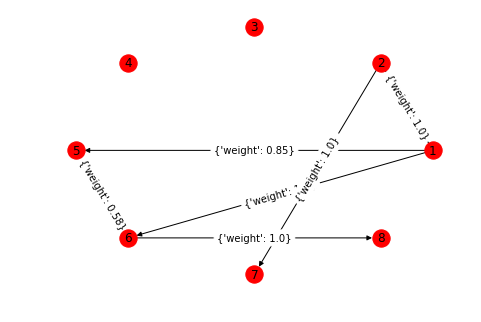

[[1.0, 1.0, 0, 0, 0.85, 1.0, 0, 0], [1.0, 1.0, 0, 0, -0.33, -1.0, 1.0, 0], [0, 0, 1.0, 0, 0, 0, 0, 0], [0, 0, 0, 1.0, 0, 0, 0, 0], [0.85, -0.33, 0, 0, 1.0, 0.58, -1.0, -0.87], [1.0, -1.0, 0, 0, 0.58, 1.0, -1.0, 1.0], [0, 1.0, 0, 0, -1.0, -1.0, 1.0, 0], [0, 0, 0, 0, -0.87, 1.0, 0, 1.0]]


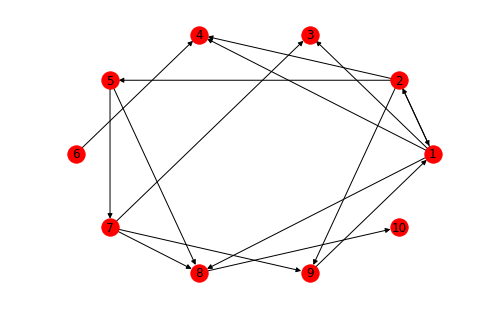

[[1, 1.0, 1.0, 1.0, 0.5, 0, 0.33, 1.0, 0.5, 0.5], [1.0, 1, 0.5, 1.0, 1.0, 0, 0.5, 0.5, 1.0, 0.33], [0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 1, 0, 0, 0, 0, 0, 0], [0.33, 0, 0.5, 0, 1, 0, 1.0, 1.0, 0.5, 0.5], [0, 0, 0, 1.0, 0, 1, 0, 0, 0, 0], [0.5, 0.33, 1.0, 0.33, 0, 0, 1, 1.0, 1.0, 0.5], [0, 0, 0, 0, 0, 0, 0, 1, 0, 1.0], [1.0, 0.5, 0.5, 0.5, 0.33, 0, 0, 0.5, 1, 0.33], [0, 0, 0, 0, 0, 0, 0, 0, 0, 1]]


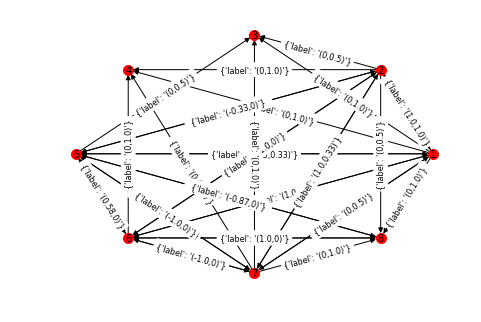

89

[[0.0, 0.0, 1.0, 1.0, 0.52, 1.0, 1.2, 1.0], [0.0, 0.0, 1.12, 1.0, 1.33, 2.24, 0.5, 1.12], [9, 9, 0.0, 9, 9, 9, 9, 9], [9, 9, 9, 0.0, 9, 9, 9, 9], [0.69, 1.66, 1.12, 9, 0.0, 1.08, 2.0, 1.87], [1.0, 2.24, 9, 1.0, 1.08, 0.0, 2.24, 1.0], [1.12, 0.67, 1.0, 1.2, 2.24, 2.24, 0.0, 1.0], [9, 9, 9, 9, 2.12, 1.0, 9, 0.0]]


In [7]:
#module for calculating similarity currently pearson similarity is used

# g is a graph that is used to show pcc similarity between users
g = nx.DiGraph()
g.add_nodes_from(unique_user_list)


#this function calculates similarity between the pair of user as needed using the pearson similarity coefficient
def calculateSimilarity(i,j,dataset1,dataset2):
    firstUser = dataset1[dataset1.userId==i]
    firstUser.columns = ['userId1','movieId','rating1']
    secondUser = dataset2[dataset2.userId==j]
    secondUser.columns = ['userId2','movieId','rating2']
    userRatings = pd.merge(firstUser,secondUser,on ='movieId')
    if(userRatings.shape[0]>1):
        temp_pcc = np.corrcoef(userRatings['rating1'].tolist(),userRatings['rating2'].tolist())[0, 1]
        pcc=round(temp_pcc,2)
    else:
        pcc = 0
    return pcc

    
# this is used to calculate similarity between every pair of users
for i in range(0,total_users):
    for j in range(0,total_users):
        if(i==j):
            similarity[i][j]=round(1.000, 2)
        else:
            y= round(calculateSimilarity(i+1,j+1,df_rating,df_rating), 2)
            if(not np.isnan(y)):
                similarity[i][j]= y
                
#for adding edges and weights to the graph g
for i in range(0,total_users):
    for j in range(i+1,total_users):
        if(similarity[i][j]>0):
            g.add_edge(i+1,j+1, weight=similarity[i][j])

            
#this code shows the edge labels and final visualization of the graph 
#here edge weights are pearson coorelation coefficient
pos = nx.circular_layout(g)
nx.draw(g,pos,with_labels=True)
nx.draw_networkx_edge_labels(g,pos)
plt.draw()
plt.show()  

print(similarity)


#########################################################################
#########################################################################
#########################################################################


#module for calculating chain of trust between users

# t is a graph that is used to show trust between users
t = nx.DiGraph()
t.add_nodes_from(unique_user_list)

rows_in_trust = df_trust.shape[0]

for i in range(0,rows_in_trust):
    t.add_edge(df_trust.loc[i, 'user1'],df_trust.loc[i, 'user2'])


pos = nx.circular_layout(t)
nx.draw(t,pos,with_labels=True)
# nx.draw_networkx_edge_labels(t,pos)
plt.draw()
plt.show()

# here input x is based on the six degree theory
# if x is 2 then it means while calculating trust between two user
# a and b there can be atmost 2 node present between them
def calculateTrustChain(x):
    for i in range(1,total_users_for_trust+1):
        for j in range(1,total_users_for_trust+1):
            if(i!=j):
                try:
                    path_length = nx.shortest_path_length(t,source=i,target=j)
                    if(path_length <= x+1):
                        trust_in_users[i-1][j-1] = round(pow(path_length,-1),2)
                    else:
                        trust_in_users[i-1][j-1] = 0
                except nx.NetworkXNoPath:
                    trust_in_users[i-1][j-1] = 0
            else:
                trust_in_users[i-1][j-1] = 1
                
                    
                
calculateTrustChain(2)
print(trust_in_users)



#########################################################################
#########################################################################
#########################################################################


#every edge of combined_graph is double weighted i.e having similarity and trust as its weights
#and the users as its nodes
combined_graph = nx.DiGraph()
combined_graph.add_nodes_from(unique_user_list)

#this loop adds edges between two nodes if there exist any edge
for i in range(0,total_users):
    for j in range(0,total_users):
        if(i!=j):
            if((trust_in_users[i][j]!=0) or (similarity[i][j]!=0)):
                combined_graph.add_edge(i+1,j+1, label='('+str(similarity[i][j])+','+str(trust_in_users[i][j])+')')
                
#this code shows the combined graph in circular fashion
pos = nx.circular_layout(combined_graph)
nx.draw(combined_graph,pos,with_labels=True,node_size=100,font_size=10)
nx.draw_networkx_edge_labels(combined_graph,pos,font_size=8)
plt.draw()
plt.show()



#########################################################################
#########################################################################
#########################################################################



# This module is to make clusters out of given novel 2d graph

#these loops are calculating the distances between a pair of users
#the formula used for calculating distance is taken from novel 2d graph algorithm
#distance of 9 tells that there is no way between pair of users to calculate distance so it denotes infinity


for i in range(0,total_users):
    for j in range(0,total_users):
        if(similarity[i][j]!=0 or trust_in_users[i][j]!=0):
            d_s = 1-similarity[i][j]
            d_t = 1-trust_in_users[i][j]
            d_s_2 = d_s**2
            d_t_2 = d_t**2
            temp = d_s_2+d_t_2
            distance = round(temp**0.5,2)
            user_pair_distance[i][j]=distance
        else:
            #here distance of 9 tells that there is no way between this pair of users so infinite distance
            user_pair_distance[i][j]=9
            


print(user_pair_distance)

file.write("Construction of Novel 2D Graph Completed!!!!\n")
file.write("-----------------Printing the user_pair_distance matrix------------------------------\n")

for item in user_pair_distance:
    for sub_item in item:
        file.write("%s\t" % sub_item)
    file.write("\n")


file.write("\n\n\n")
file.write("----------------------------------------------------------------------------------------\n")


### Generating Feasible Partitioning

In [8]:
# file.write("Started Generating Feasible Partitioning............\n")

def kmedoids(number_of_clusters):
    chosen_clusters=[]
    final_clusters=[]
    for i in range(0,number_of_clusters):
        x=random.randint(1,total_users)
        while(x in chosen_clusters):
            x=random.randint(1,total_users)
        chosen_clusters.append(x)
    for j in chosen_clusters:
        final_clusters.append([j])
    cont=True
    while(cont):
        for i in range(0,total_users):
            if(not any(i+1 in sublist for sublist in final_clusters)):
                min_distance=10
                allocate_cluster=0
                for j in range(0,number_of_clusters):
                    temp_cluster=final_clusters[j][0]
                    if(min_distance>=user_pair_distance[i][temp_cluster-1]):
                        min_distance=user_pair_distance[i][temp_cluster-1]
                        allocate_cluster=j
                final_clusters[allocate_cluster].append(i+1)
        cont=False
        row_num=0
        modification_dict={}
        for i in final_clusters:
            min_cluster_distance=99999
            for j in range(0,len(i)):
                total_sum=0
                avg=0
                for k in range(0,len(i)):
                    if(i[j]!=i[k]):
                        total_sum +=user_pair_distance[i[j]-1][i[k]-1]
                avg=total_sum/len(i)
                if(min_cluster_distance>avg):
                    min_cluster_distance=avg
                    min_cluster=i[j]
            if(min_cluster!=i[0]):
                cont=True
                modification_dict[row_num]=min_cluster                
            row_num+=1            
        if(cont):
            final_clusters=[]
            for z in chosen_clusters:
                    final_clusters.append([z])
            for key in modification_dict:
                    final_clusters[key][0]=modification_dict[key]
#     print(chosen_clusters)
#     print(final_clusters)
#     for i in range(0,len(final_clusters)):
#         cluster_centers.append(final_clusters[i][0])
    return final_clusters    





#########################################################################
#########################################################################
#########################################################################





#this code checks the distance of each user in the test dataset with the 
#clusters and assigns nearest cluster to the user in the test dataset

def testUserDict(cluster_centers):
    
    testSetUser=test.userId.unique().tolist()
    targetClusterTestUserDict={}
    
#     print(cluster_centers)


    for i in range(0,len(testSetUser)):
        nearestClusterIndex=0
        minDistance=10
        for j in range(0,len(cluster_centers)):

            pcc_simi=calculateSimilarity(testSetUser[i],cluster_centers[j][0],test,df_rating)
            temp1=testSetUser[i]-1
            temp2=cluster_centers[j][0]-1
            trust_simi=trust_in_users[temp1][temp2]
            if(pcc_simi!=0 or trust_simi!=0):
                d_s = 1-pcc_simi
                d_t = 1-trust_simi
                d_s_2 = d_s**2
                d_t_2 = d_t**2
                temp = d_s_2+d_t_2
                distance = round(temp**0.5,2)
            else:
                #here distance of 9 tells that there is no way between this pair of users so infinite distance
                distance=9
            if(minDistance>distance):
                minDistance=distance
                nearestClusterIndex=j
        targetClusterTestUserDict[testSetUser[i]]=nearestClusterIndex

    return targetClusterTestUserDict


#########################################################################
#########################################################################
#########################################################################


#it calculates rating coverage for the system using the test dataset
def rating_coverage(clusters,targetClusterTestUserDict):
    count=0
    length=test.shape[0]
    for i in range(0,length):
        userBelongsToCluster=targetClusterTestUserDict[test.iloc[i]['userId']]
        itemid=test.iloc[i]['movieId']
        for j in clusters[userBelongsToCluster]:
            rowNum=df_rating[(df_rating.userId==j)&(df_rating.movieId==itemid)].empty
            if(not rowNum):
                count+=1
                break;       
    rc=count/length
    rc=round(rc,2)
    return rc*100




#########################################################################
#########################################################################
#########################################################################



#it checks and decides optimal number of clusters according to given rate of coverage
def feasible_partitioning(MARC):
    rc=100
    i=1
    partition1=[]
    partition2=[]
    while(rc>=MARC):
        i=i+1
        partition2=kmedoids(i)
        targetClusterTestUserDict=testUserDict(partition2)
        rc = rating_coverage(partition2,targetClusterTestUserDict)
        partition1=partition2
    final_cluster=partition1
    return partition1

In [9]:
file.write("------------------------Started Generating Feasible Partitioning--------------------------------------------\n")

abc=feasible_partitioning(70)
file.write("Completed Feasible Partitioning!!!\n")

file.write("-----------------------Printing the output of feasible partitioning at MARC=70--------------------\n")
# abc

for item in abc:
    for sub_item in item:
        file.write("%s\t" % sub_item)
    file.write("\n")

file.write("\n\n\n")

file.write("---------------------------------------------------------------------------------------------------\n")

100

### Calculating optimal parameters i.e alpha, beta and gamma for each cluster

In [10]:
#wuv is the convex combination of pearson,jaccard and trust
#it is calculated between user u and user v

def WUV(alpha,beta,gamma,u,v):
    pcc=calculateSimilarity(u,v,test,df_rating)
    trust=trust_in_users[u-1][v-1]
    jac=jaccard(trust_in_users[u-1],trust_in_users[v-1])
    temp_total=alpha*pcc + beta*trust + gamma*jac
    total=round(temp_total,2)
    return total




#########################################################################
#########################################################################
#########################################################################


#jaccard is needed to calculate wuv 

def jaccard(a, b):
    intersection=0
    union=0
    for i in range(0,10):
        if(a[i]!=0 and b[i]!=0):
            intersection +=1
            union +=1
        elif(a[i]!=0):
            union +=1
        elif(b[i]!=0):
            union +=1
    return float(intersection/union)



#########################################################################
#########################################################################
#########################################################################



#this code predicts the rating for a given user and movie by taking the trust and similarity into consideration

def predict_rating(final_clusters,userFromTest,userBelongsToCluster,itemid,alpha,beta,gamma):
#     userBelongsToCluster=targetClusterTestUserDict[userFromTest]
    sum1=0
    sum2=0
    for i in range(0,len(final_clusters[userBelongsToCluster])):
        clusterUser=final_clusters[userBelongsToCluster][i]
        rowNum=df_rating[(df_rating.userId==clusterUser)&(df_rating.movieId==itemid)].empty
        if(not rowNum):
            clusterUserRating=df_rating[(df_rating.userId==clusterUser)&(df_rating.movieId==itemid)]['rating'].tolist()[0]
#             print("rating=",clusterUserRating,"end")
#             print(clusterUserRating.shape)
            temp_wuv=WUV(alpha,beta,gamma,userFromTest,clusterUser)
            sum1+=temp_wuv*clusterUserRating
            sum2+=abs(temp_wuv)
    if(sum2==0):
        sum2=1
       
    prediction=sum1/sum2
    return round(prediction,2)


#########################################################################
#########################################################################
#########################################################################



#this code calculates the mean absoluter error of the system

def calc_MAE(a,b,c,cluster,targetClusterTestUserDict,final_clusters):
    real_rating=[]
    predicted_rating=[]
    length=test.shape[0]
    
    for i in range(0,length):
        
        userBelongsToCluster=targetClusterTestUserDict[test.iloc[i]['userId']]
        
        if(userBelongsToCluster==cluster):
            real_rating.append(test.iloc[i]['rating'])
            temp_rating=predict_rating(final_clusters,test.iloc[i]['userId'],cluster,test.iloc[i]['movieId'],a,b,c)
            predicted_rating.append(temp_rating)
    
    diff = [abs(x - y) for x, y in zip(real_rating, predicted_rating)]
    diff_sum=sum(diff)
    length=len(diff)
#     print(real_rating)
#     print(predicted_rating)
    if(length != 0):
        mae=diff_sum/length
    else:
        mae=0
    return mae




#########################################################################
#########################################################################
#########################################################################


#this code checks which value of alpha,beta and gamma gives the minimum mean absolute error for a given cluster

def optimal_parameter(cluster,targetClusterTestUserDict,final_clusters):
    min=999
    temp_alpha=0
    temp_beta=0
    temp_gamma=1
    for i in range(0,11,1):
        for j in range(0,11,1):
            a=0.1*i
            b=0.1*j
            c=1-a-b
            mae = calc_MAE(a,b,c,cluster,targetClusterTestUserDict,final_clusters)
            if(mae < min):
                min = mae
                temp_alpha = a
                temp_beta = b
                temp_gamma = c
    alpha=round(temp_alpha,2)
    beta=round(temp_beta,2)
    gamma=round(temp_gamma,2)
    return alpha,beta,gamma


#########################################################################
#########################################################################
#########################################################################



#this code assigns optimal values of alpha,beta and gamma for each cluster

def ABGof_cluster():
    final_clusters=feasible_partitioning(70)
    print(final_clusters)
    targetClusterTestUserDict=testUserDict(final_clusters)
    length=len(final_clusters)
    final_alpha=[]
    final_beta=[]
    final_gamma=[]
    for i in range(0,length):
        tempa,tempb,tempc=optimal_parameter(i,targetClusterTestUserDict,final_clusters)
        final_alpha.append(tempa)
        final_beta.append(tempb)
        final_gamma.append(tempc)
    
    file.write("Completed Calculation!!!\n")
    
    file.write("------------------------Printing final_alpha variable values for each cluster------------------------\n")
    
    for sub_item in final_alpha:
        file.write("%s\t" % sub_item)
        
    file.write("\n\n\n")
    file.write("----------------------------------------------------------------------------------------------------------\n")
    
    file.write("------------------------Printing final_beta variable values for each cluster------------------------\n")
    
    for sub_item in final_beta:
        file.write("%s\t" % sub_item)
    
    file.write("\n\n\n")
    file.write("----------------------------------------------------------------------------------------------------------\n")
    
    
    file.write("------------------------Printing final_gamma variable values for each cluster------------------------\n")
    
    for sub_item in final_gamma:
        file.write("%s\t" % sub_item)
    
    file.write("\n\n\n")
    file.write("----------------------------------End Of Output File------------------------------------------------------------------------\n")
    
    
    print(final_alpha)
    print(final_beta)
    print(final_gamma)


    
    

#########################################################################
#########################################################################
#########################################################################

In [11]:
file.write("Started Calculating optimal parameters i.e alpha, beta and gamma for each cluster............\n")
ABGof_cluster()

[[7], [1, 2, 6], [5, 3, 4, 8]]
[0.0, 0.3, 0.0]
[0.0, 0.0, 0.0]
[1.0, 0.7, 1.0]


In [12]:
file.close()